# Entegable 1- Métricas, Árboles de decisión y Random Forest

Francisco Javier Mercader Martínez

## Machine Learning. Grado en Ciencia de datos

Los siguientes ejercicios tienen que ser entregados dentro de las dos horas de prácticas. Como realizar el entregable:


-   La realización se debe de hacer de forma  **INDIVIDUAL**
-   Se debe de enviar un notebook con el código y las explicaciones, comentarios, análisis y justificaciones en Markdown.
-   Reproducibilidad:
    -   Se debe de establecer una variable semilla con un número al inicio, esta variables será la que se utilice para el np.random_seed y para el random_state.
    -   Las bases de datos se cargan con rutas relativas.
-   El notebook se debe de subir a la tarea del aula virtual creada antes de la finalización de la hora de clase. (Ver tarea y fecha de cierre)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

In [2]:
semilla = 456
np.random.seed(semilla)

### Ejercicio 1

Utilizando el dataset banco.csv, crea el árbol de decisión que consideres para realizar la clasificación de la columna depósito. Para ello, sigue los siguientes pasos:
   1. Carga el dataset y revisa los tipos de datos de los atributos para analizar si es necesario transformar alguno. En caso necesario realiza la transformación.
   2. Crear un hold-out (train-test) 80-20.
   3. Crear un árbol de decisión y establecer si es necesario realizar poda o no.
   4. Para el árbol sin podar calcular las métricas conocidas para analizar si la clasificación es buena o mala. Mínimo calcular 4 métricas. Tras el cálculo de las métricas analiza los resultados. 
   5. Para el árbol con poda, si la poda fuera necesaria, calcular las métricas conocidas para analizar si la clasificación es buena o mala. Mínimo calcular 4 métricas. Tras el cálculo de las métricas analiza los resultados. 
   6. Ahora crea una validación cruzada de 5 folds o subconjuntos y entrena el árbol de nuevo y calcula de nuevo las mismas métricas que en el apartado 4. Compara los resultados, ¿hay diferencias, a qué se deben? Justifica tus respuestas. 
   7. En base a los resultados obtenidos en los apartados anteriores ¿El árbol de decisión sería un modelo, estable robusto y recomendable para predecir si los clientes van a realizar o no un depósito?

   Nota: Este dataset intenta clasificar en base a unas características de las personas y el tiempo de una llamada (edad, tipo de trabajo, estado, educación, tiempo de duración de la llamada, si tienes préstamos, etc), si los clientes terminarán contratando o no un depósito en un banco. 

In [3]:
# Apartado 1
banco = pd.read_csv('banco 2.csv', sep=";")
print(banco.dtypes)

# Según los tipos de datos, parece que hay varias variables categóricas que necesitan ser transformadas

cols = ['trabajo', 'estado', 'educacion', 'presCasa', 'prestamo', 'contacto', 'mes', 'dia']
encoder = LabelEncoder()

for col in cols:
    banco[col] = encoder.fit_transform(banco[col])

print(banco)

edad          int64
trabajo      object
estado       object
educacion    object
presCasa     object
prestamo     object
contacto     object
mes          object
dia          object
duracion      int64
deposito      int64
dtype: object
     edad  trabajo  estado  educacion  presCasa  prestamo  contacto  mes  dia  \
0      30        1       1          2         2         0         0    6    0   
1      39        7       2          3         0         0         1    6    0   
2      25        7       1          3         2         0         1    4    4   
3      38        7       1          2         1         1         1    4    0   
4      47        0       1          5         2         0         0    7    1   
..    ...      ...     ...        ...       ...       ...       ...  ...  ...   
798    30        0       1          1         2         2         0    3    2   
799    39        0       1          3         2         0         1    3    0   
800    27        8       2          3

In [4]:
# Apartado 2
from sklearn.model_selection import train_test_split

X = banco.drop(columns="deposito", axis=1)
y = banco["deposito"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Mejor parámetro:  {'ccp_alpha': np.float64(0.01)}


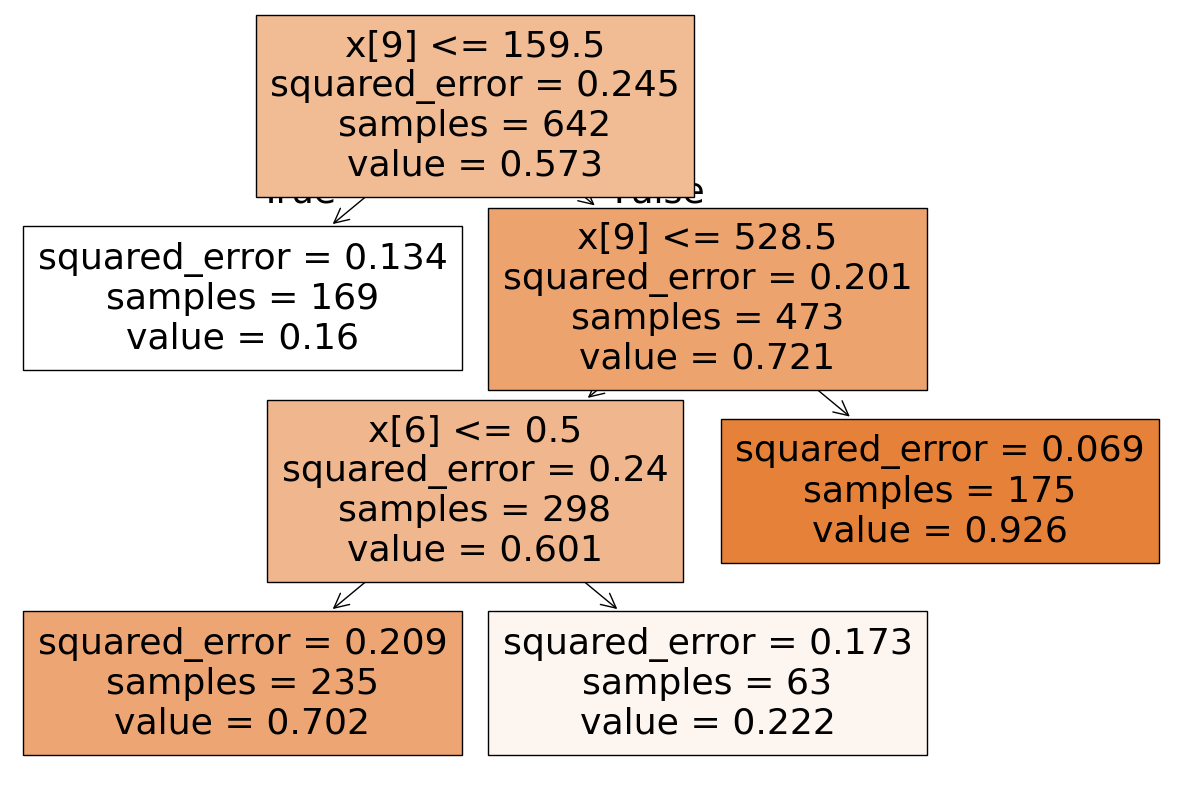

In [5]:
# Apartado 3
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV

# Crear un árbol de regresión y entrenarlo
reg = DecisionTreeRegressor(max_depth=None)
reg.fit(X_train, y_train)

# Verificar si es necesario hacer poda y cuál sería el mejor parámetro para realizarla
param_grid = {'ccp_alpha': np.arange(0, 1, 0.01)}
grid = GridSearchCV(reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

print("Mejor parámetro: ", grid.best_params_)

# Dibujar el árbol creado con poda si esta fuera necesaria
if grid.best_params_['ccp_alpha'] > 0:
    reg_poda = DecisionTreeRegressor(max_depth=None, ccp_alpha=grid.best_params_['ccp_alpha'], random_state=123)
    reg_poda.fit(X_train, y_train)
    
    plt.figure(figsize=(15,10))
    plot_tree(reg_poda, filled=True)
    plt.show()

In [6]:
# Apartado 4

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Crear y entrenar el árbol de decisión
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

# Predecir las etiquetas para el conjunto de prueba
y_pred = dtc.predict(X_test)

# Calcular las métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.6832
Precision: 0.6818
Recall: 0.7229
F1 Score: 0.7018


Las métricas no son malas ya que son valores son mucho mayores de 0 pero tampoco podemos afirmar que sean muy buenas ya que distan bastante de valer 1, por lo tanto, en un lenguaje más coloquial podríamos decir que tiene valores *"medianamente buenos"*.

In [7]:
# Apartado 5

# Crear y entrenar el árbol de decisión con poda
dtc_poda = DecisionTreeClassifier(ccp_alpha=grid.best_params_['ccp_alpha'])
dtc_poda.fit(X_train, y_train)

# Predecir las etiquetas para el conjunto de prueba
y_pred_poda = dtc_poda.predict(X_test)

# Calcular las métricas
accuracy_poda = accuracy_score(y_test, y_pred_poda)
precision_poda = precision_score(y_test, y_pred_poda)
recall_poda = recall_score(y_test, y_pred_poda)
f1_poda = f1_score(y_test, y_pred_poda)

print(f"Accuracy: {accuracy_poda:.4f}")
print(f"Precision: {precision_poda:.4f}")
print(f"Recall: {recall_poda:.4f}")
print(f"F1 Score: {f1_poda:.4f}")

Accuracy: 0.7764
Precision: 0.7374
Recall: 0.8795
F1 Score: 0.8022


Las métricas no son malas ya que son valores son mucho mayores de 0 pero tampoco podemos afirmar que sean muy buenas ya que distan bastante de valer 1. Sin embargo gracias a la poda sus valores se han incrementado bastante con respecto a los datos obtenidos en el apartado anterior, así que podríamos decir que estos datos son *"bastante buenos"*.

In [8]:
# Apartado 6
from sklearn.model_selection import cross_val_score

dtc2 = DecisionTreeClassifier()

# Realizar una validación cruzada de 5 folds
scores = cross_val_score(dtc2, X_train, y_train, cv=5)

print(f"Resultados de la Validación Cruzada: {scores}")

dtc2.fit(X_train, y_train)

# Predecir las etiquetas para el conjunto de prueba
y_pred = dtc.predict(X_test)

# Calcular las métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Resultados de la Validación Cruzada: [0.72093023 0.68217054 0.7890625  0.6875     0.7734375 ]
Accuracy: 0.6832
Precision: 0.6818
Recall: 0.7229
F1 Score: 0.7018


Se obtienen los mismo resultados en ambos casos apartados.

```python
# Apartado 7
```

Los resultados de los apartados anteriores sugieren que el modelo tiene un rendimiento decente, pero en este caso como se pide que los clientes realicen un depósito es posible que se prefiriese un modelo con una precisión más alta.

### Ejercicio 2

Utilizando el dataset AirQuality.csv, crea el Random Forest que consideres para realizar la regresión de la columna monoxido de carbono (CO). Para ello, sigue los siguientes pasos:
   1. Carga el datasets y revisa los tipos de datos de los atributos del dataset, analizar si es necesario transformar alguno. En caso de ser necesario realiza la transformación
   2. Crear un hold-out (train-test) 70-30.
   3. Crear el random forest, estableciendo al menos 4 parámetros.
   4. Calcula al menos 2 métricas. Tras el cálculo de las métricas analiza los resultados. 
   5. Realiza una búsqueda de los mejores hiperparámetros, emplee 3 hiperparámetros en la búsqueda.
   6. Compara los resultados del  ensamble con los méjores parámetros y con los parámetros establecidos inicialmente. Analiza los resultados e indica cuáles son los principales cambios en los parámetros y el porqué mejora o empeora el resultado.
   7. El modelo creado, ¿es un modelo fiable?

   Descripción del Dataset: Este dataset contiene medidas de valores de calidad del aire. El objetivo es analizar si es posible calcular el monóxido de carbono CO que hay en el aire a partir de los otros atributos (Temperatura, humedad relativa y absoluta, concentraciones de benceno, de óxido nítrico, de dioxido de nitrógeno y de Hidrocarburos no Metánicos)

In [9]:
# Apartado 1
air = pd.read_csv("AirQuality 2.csv", sep = ";")

print(air.dtypes)

print(air)

CO      float64
NMHC      int64
C6H6    float64
Nox       int64
NO2       int64
T       float64
RH      float64
AH      float64
dtype: object
      CO  NMHC  C6H6  Nox  NO2     T    RH      AH
0    2.6   150  11.9  166  113  13.6  48.9  0.7578
1    2.0   112   9.4  103   92  13.3  47.7  0.7255
2    2.2    88   9.0  131  114  11.9  54.0  0.7502
3    2.2    80   9.2  172  122  11.0  60.0  0.7867
4    1.6    51   6.5  131  116  11.2  59.6  0.7888
..   ...   ...   ...  ...  ...   ...   ...     ...
822  4.4   501  19.5  254  133  19.1  61.1  1.3345
823  3.1   234  15.1  189  110  18.2  65.4  1.3529
824  3.0   212  14.6  174  102  18.1  66.1  1.3579
825  3.1   275  13.7  167  108  17.7  66.9  1.3422
826  3.5   275  15.2  185  110  17.8  66.8  1.3460

[827 rows x 8 columns]


In [10]:
# Apartado 2
X = air.drop(columns="CO")

y = air["CO"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
# Apartado 3
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor

# Crear y entrenar el Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0, min_samples_split=2)

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Apartado 4

rf.fit(X_train, y_train)

# Predecir las etiquetas para el conjunto de prueba
y_pred = rf.predict(X_test)

# Calcular y mostrar las métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.23073811206258824
Mean Absolute Error: 0.3541724778045469


In [13]:
# Apartado 5

from sklearn.model_selection import GridSearchCV

# Definir los hiperparámetros que quieres buscar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Ajustar el objeto GridSearchCV a los datos
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print(grid_search.best_params_)

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [14]:
# Apartado 6

# Crear y entrenar el modelo con los mejores parámetros
rf_best = RandomForestRegressor(**grid_search.best_params_, random_state=0)
rf_best.fit(X_train, y_train)

# Predecir las etiquetas para el conjunto de prueba
y_pred_best = rf_best.predict(X_test)

# Calcular y mostrar las métricas para el modelo con los mejores parámetros
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
print(f'Best model - Mean Squared Error: {mse_best}')
print(f'Best model - Mean Absolute Error: {mae_best}')

Best model - Mean Squared Error: 0.07267529116465861
Best model - Mean Absolute Error: 0.18561445783132532


```python
# Ejericicio 7
```
